In [26]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import os
import warnings
warnings.filterwarnings('ignore')

In [27]:
stores = gpd.read_file('DETER_POI.shp')
paths = gpd.read_file('COVID-19.shp')
store_path_50 = gpd.read_file('Point_50_SpatialJoin.shp')
store_path_20 = gpd.read_file('Point_20_SpatialJoin.shp')
store_path_50['Name'] = store_path_50['Name'].fillna('0')
store_path_20['Name'] = store_path_20['Name'].fillna('0')
store_path_50 = store_path_50[store_path_50['Name'] != '0']
store_path_20 = store_path_20[store_path_20['Name'] != '0']

In [28]:
data_50 = pd.merge(store_path_50[['placekey','Name']],paths,on='Name',how='left')
data_20 = pd.merge(store_path_20[['placekey','Name']],paths,on='Name',how='left')

In [30]:
#for i in data_50.iloc[:,3].columns

<AxesSubplot:>

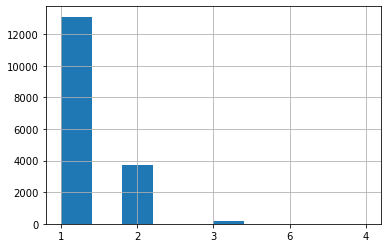

In [31]:
#Number_of_分 Walk_alone_Y/Walk_alone_N
data_50['Number_of_'].hist()

<AxesSubplot:>

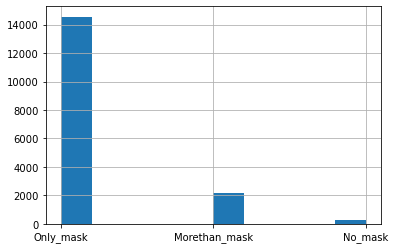

In [32]:
#PPE_type       No_mask/Only_mask/Morethan_mask
data_50['PPE_type'].unique()

def protection(record):
    if record in ['Mask', 'mask','MASK','Mask (double)','masks']:
        return 'Only_mask'
    elif record in ['N/A','NA','n/a','no mask']:
        return 'No_mask'
    elif record is None:
        return 'No_mask'
    else:
        return 'Morethan_mask'

data_50['PPE_type'].map(protection).hist()

In [33]:
#Start_Time, End_Time
def right_time(record):
    if record is None:
        correct_time=0
    elif len(record)==5:
        correct_time = int(record[:2])*60+int(record[3:5])
    elif len(record)==8:
        correct_time = int(record[:2])*60+int(record[3:5])
    elif len(record)==4 and record[2]==':':
        correct_time = int(record[:1])*60+int(record[2:])
    elif len(record)==7:
        correct_time = int(record[:2])*60+int(record[3:5])
    else:
        correct_time=0
    return correct_time

(data_50['End_Time'].map(right_time)-data_50['Start_Time'].map(right_time)).mean()

9.92947664867402

In [34]:
#Interim_de 
data_50['Interim_de'].map(lambda x: 'Y' if not x is None else 'N')
print(len(data_50['Interim_de'].dropna()))

7073


In [35]:
#Touch1, Touch2
print(len(data_50['Touch1'].dropna()))
print(len(data_50['Touch2'].dropna()))

def touch(record):
    if (not record['Touch1'] is None) or (not record['Touch2'] is None):
        return 'Y'
    else:
        return 'N'


aa = data_50[['Touch1','Touch2']].apply(touch,axis=1)
len(aa[aa=='Y'])

9511
3574


9639

In [36]:
def attribute_process(data):
    results = data.copy(deep=True)
    results['Walk_alone'] = results['Number_of_'].map(lambda x: 'Y' if x=='1' else 'N')
    results['Duration'] = results['End_Time'].map(right_time) - results['Start_Time'].map(right_time)
    results['Long_path'] = results['Duration'].map(lambda x: 'Y' if x>=10 else 'N')
    results['Stop'] = results['Interim_de'].map(lambda x: 'Y' if not x is None else 'N')
    results['Touch'] = results[['Touch1','Touch2']].apply(touch,axis=1)
    results['Protection'] = results['PPE_type'].map(protection)
    return results[['placekey','Name','Walk_alone','Long_path','Stop','Touch','Protection']]

In [37]:
aa = attribute_process(data_50)
aa.head()

,placekey,Name,Walk_alone,Long_path,Stop,Touch,Protection
0,zzy-223@627-wc7-st9,20210108bd01,Y,N,N,N,Only_mask
1,zzy-223@627-wc7-st9,20210108bd02,Y,N,N,N,Only_mask
2,zzy-223@627-wc7-st9,20210108bd03,N,N,N,N,Only_mask
3,zzy-223@627-wc7-st9,20210108bd04,Y,N,N,N,Only_mask
4,zzy-223@627-wc7-st9,20210108bd05,Y,N,N,N,Only_mask


In [38]:
def path_count(data,stores):
    results = pd.DataFrame(index = stores['placekey'])
    for i in data.columns[2:]:
        for j in data[i].unique():
            results[i+'_'+j] = data[data[i]==j].groupby('placekey').agg({'Name':'count'})
    results['Total'] = data.groupby('placekey').agg({'Name':'count'})
    return results.reset_index()

<AxesSubplot:>

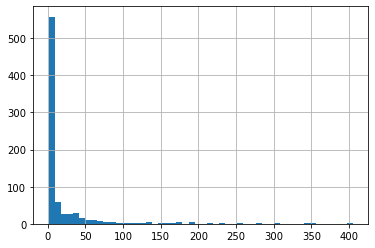

In [39]:
#####
results_50 = path_count(attribute_process(data_50),stores)
results_50 = results_50.fillna(0)
results_50['Total'].hist(bins=50)

<AxesSubplot:>

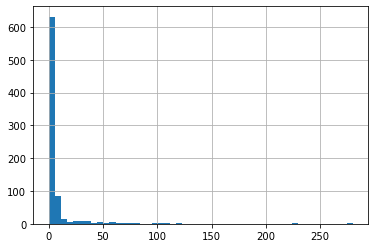

In [40]:
results_20 = path_count(attribute_process(data_20),stores)
results_20 = results_20.fillna(0)
results_20['Total'].hist(bins=50)

In [41]:
results_50.to_csv('DETER_POI_data.csv')

##### Test

In [59]:
results_50 = pd.read_csv('DETER_POI_data.csv').iloc[:,1:]

In [61]:
test1 = results_20[results_20.placekey.isin(['22g-222@627-rwb-qzz','225-222@627-rwb-qzz'])]

In [62]:
test2 = results_50[results_50.placekey.isin(['223-222@627-s8j-td9','22z-222@627-s96-rff','22q-223@627-s8j-5fz'])]

In [63]:
test1

,placekey,Walk_alone_N,Walk_alone_Y,Long_path_N,Long_path_Y,Stop_N,Stop_Y,Touch_N,Touch_Y,Protection_Only_mask,Protection_Morethan_mask,Protection_No_mask,Total
751,22g-222@627-rwb-qzz,4.0,14.0,11.0,7.0,4.0,14.0,14.0,4.0,15.0,0.0,3.0,18.0
763,225-222@627-rwb-qzz,4.0,9.0,9.0,4.0,2.0,11.0,10.0,3.0,10.0,0.0,3.0,13.0


In [64]:
compare = results_50[results_50.placekey.isin(placekey_lst)]
compare

,placekey,Walk_alone_Y,Walk_alone_N,Long_path_N,Long_path_Y,Stop_N,Stop_Y,Touch_N,Touch_Y,Protection_Only_mask,Protection_Morethan_mask,Protection_No_mask,Total
133,223-222@627-s8j-td9,3.0,3.0,0.0,6.0,4.0,2.0,4.0,2.0,6.0,0.0,0.0,6
306,22q-223@627-s8j-5fz,1.0,2.0,0.0,3.0,3.0,0.0,3.0,0.0,3.0,0.0,0.0,3
597,22z-222@627-s96-rff,83.0,22.0,69.0,36.0,95.0,10.0,69.0,36.0,93.0,6.0,6.0,105


In [65]:
#input a list of placekey name, 50m/20m path counts
def pair_compare(placekey_lst, data, print_pie = False):
    compare = data[data.placekey.isin(placekey_lst)]
    for i in compare.iloc[:,1:-1].columns:
        compare[i] = compare[i]/compare['Total']
    
    aa = compare.T[1:]
    pro_difference_lst = []
    num_difference_lst = []
    for j in range(len(placekey_lst)):
        aa['Difference'] = np.abs(aa.iloc[:,0]-aa.iloc[:,j])
        pro_difference = aa['Difference'][:-1].sum()
        num_difference = np.abs(aa.iloc[-1:,0]-aa.iloc[-1:,j]).values[0]
        pro_difference_lst.append(pro_difference)
        num_difference_lst.append(num_difference)
    pro_difference = max(pro_difference_lst)
    num_difference = max(num_difference_lst)
    
    if print_pie == True:
        fig, ax = plt.subplots(nrows=len(placekey_lst), ncols=5,figsize=(18,len(placekey_lst)*4))
        for i in range(len(placekey_lst)):
            ax[i,0].pie(compare.iloc[i,1:3], labels=[compare.iloc[i,1:3].index[0], compare.iloc[i,1:3].index[1]],autopct='%1.1f%%',startangle=-270)
            ax[i,1].pie(compare.iloc[i,3:5], labels=[compare.iloc[i,3:5].index[0], compare.iloc[i,3:5].index[1]],autopct='%1.1f%%',startangle=-270)
            ax[i,2].pie(compare.iloc[i,5:7], labels=[compare.iloc[i,5:7].index[0], compare.iloc[i,5:7].index[1]],autopct='%1.1f%%',startangle=-270)
            ax[i,3].pie(compare.iloc[i,7:9], labels=[compare.iloc[i,7:9].index[0], compare.iloc[i,7:9].index[1]],autopct='%1.1f%%',startangle=-270)
            ax[i,4].pie(compare.iloc[i,9:12], labels=[compare.iloc[i,9:12].index[0], compare.iloc[i,9:12].index[1], compare.iloc[i,9:12].index[2]],autopct='%1.1f%%',startangle=-270)
            ax[i,0].set_title(placekey_lst[i],fontsize=12)

    print([pro_difference, num_difference])
    return [pro_difference, num_difference]

[3.333333333333333, 102]


[3.333333333333333, 102]

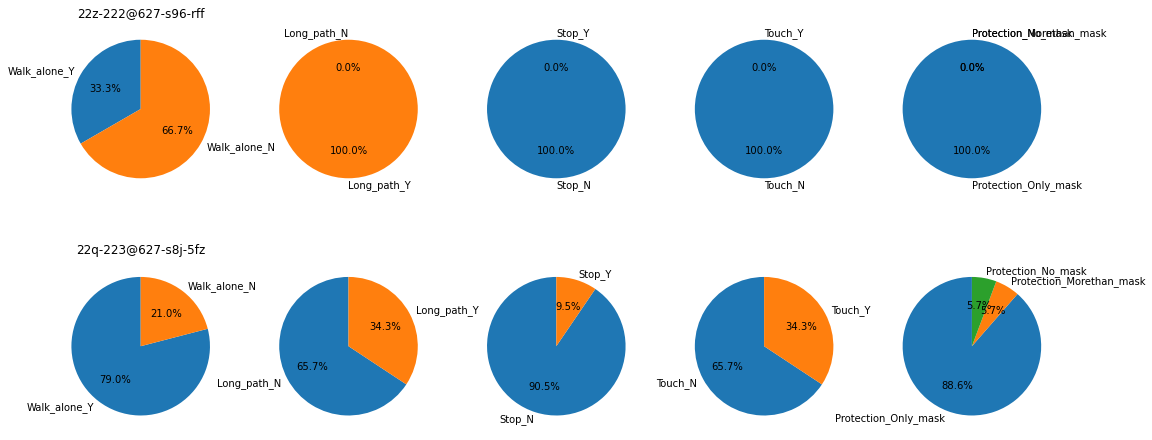

In [67]:
#placekey_lst = ['223-222@627-s8j-td9','22z-222@627-s96-rff','22q-223@627-s8j-5fz']
#placekey_lst = ['22g-222@627-rwb-qzz','225-222@627-rwb-qzz']
placekey_lst = ['22z-222@627-s96-rff','22q-223@627-s8j-5fz']
pair_compare(placekey_lst, results_50, print_pie = True)